In [34]:
import jax
import jax.numpy as jnp
import numpy as np

from jax import grad, jit, vmap, pmap

from jax import random
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import Tuple, NamedTuple
import functools

### Let's train a model in parallel

In [35]:
class Params(NamedTuple):
    weight: jnp.ndarray
    bias: jnp.ndarray

lr = 0.005

def init_model(rng):
    weights_key, bias_key = jax.random.split(rng)
    weights = jax.random.normal(weights_key, ())
    biases = jax.random.normal(bias_key, ())
    return Params(weights, biases)

def forward(params, xs):
    return params.weight * xs + params.bias

def loss_fn(params, xs, ys):
    pred = forward(params, xs)
    # MSE
    return jnp.mean((pred-ys)**2)

In [36]:
# By decirating the function using pmap here, we wont need to wrap it 
# in pmap when we call it
@functools.partial(jax.pmap, axis_name='batch')
def update(params, xs, ys):

    # Compute gradients on given mini batch (individually on each device)
    loss, grads = jax.value_and_grad(loss_fn)(params, xs, ys)

    # Combine the gradient across all devices (by taking mean)
    grads = jax.lax.pmean(grads, axis_name='batch')

    # Combine the loss (Unnecessary for update, useful for logging)
    loss = jax.lax.pmean(loss, axis_name='batch')

    # Each device performs their own SGD Update.
    # But since we start with same params and sync gradients,
    # the params stay in sync on each device

    new_params = jax.tree.map(
        lambda param, g: param - g*lr, params, grads
    )

    # If we were using ADAM or a stateful optimizer, we would do something like:
    # updates, new_optimizer_state = optimizer(grads, optimizer_state)
    # Then use updates instead of grads to actually update the params.
    # And include new_optimizer_state in outputs, naturally.

    return new_params, loss

#### Generating true data

In [37]:
# Generate True data from y = wx + b + noise
true_w, true_b = 32, -12
xs = np.random.normal(size=(128, 1))
noise = 5*np.random.normal(size=(128,1))

ys = xs*true_w + true_b + noise

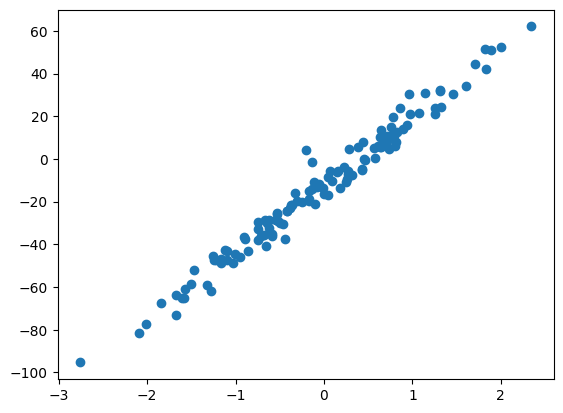

In [38]:
plt.scatter(xs, ys)
plt.show()

#### Initialize Parameter, Replicate across devices

In [39]:
params = init_model(jax.random.PRNGKey(0))
n_devices = jax.local_device_count()
replicated_params = jax.tree.map(lambda x: jnp.array([x]*n_devices), params)
print(replicated_params)

Params(weight=Array([1.0040143], dtype=float32), bias=Array([-2.4424558], dtype=float32))


#### Prepare the data

In [40]:
def reshape_for_pmap(data, n_devices):
    return data.reshape(n_devices, data.shape[0]//n_devices, *data.shape[1:])

In [41]:
x_parallel = reshape_for_pmap(xs, n_devices)
y_parallel = reshape_for_pmap(ys, n_devices)

print(x_parallel.shape, y_parallel.shape)

(1, 128, 1) (1, 128, 1)


In [42]:
def type_after_update(name, obj):
    print(f"After first 'update()', '{name}' is a {type(obj)}")

#### Actual Training Loop

In [43]:
num_epochs = 1000
for epoch in range(num_epochs):

    # This is where params and data gets communicated to devices
    replicated_params, loss = update(replicated_params, x_parallel, y_parallel)

    # replicated_params and loss are  now both ShardedDeviceArrays,
    # indicating that they are on devices
    # x/y_parallel remains a NumPy array on the host (simmulating data storage)
    if epoch == 0:
        type_after_update('replicated_params.weight', replicated_params.weight)
        type_after_update('loss', loss)
        type_after_update('x_parallel', x_parallel)
    
    if epoch % 100 == 0:
        print(loss.shape)
        print(f"Step {epoch:3d}, loss: {loss[0]:.3f}")

# Like the loss, leaves of the params have extra leading dimension
# so we take the params from the first device
params = jax.device_get(jax.tree.map(lambda x: x[0], replicated_params))


After first 'update()', 'replicated_params.weight' is a <class 'jaxlib._jax.ArrayImpl'>
After first 'update()', 'loss' is a <class 'jaxlib._jax.ArrayImpl'>
After first 'update()', 'x_parallel' is a <class 'numpy.ndarray'>
(1,)
Step   0, loss: 1012.495
(1,)
Step 100, loss: 164.908
(1,)
Step 200, loss: 44.136
(1,)
Step 300, loss: 26.694
(1,)
Step 400, loss: 24.142
(1,)
Step 500, loss: 23.763
(1,)
Step 600, loss: 23.707
(1,)
Step 700, loss: 23.698
(1,)
Step 800, loss: 23.697
(1,)
Step 900, loss: 23.696


#### Model Predictions

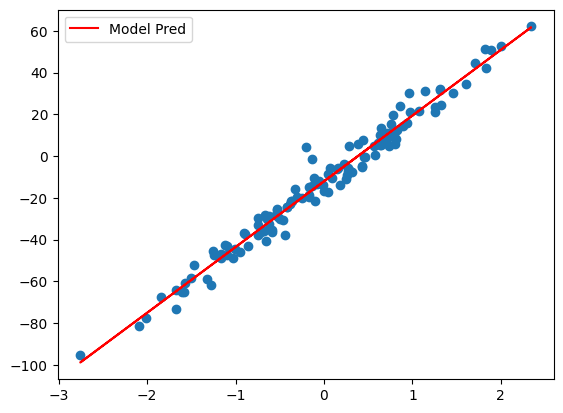

In [45]:
plt.scatter(xs, ys)
plt.plot(xs, forward(params, xs), c="red", label="Model Pred")
plt.legend()
plt.show()

#### We just trained a model in parallel on multiple devices!

#### There are some super important tools we are missing tho
1) How would we go about transfer learning in JAX?
2) How do we freeze certain layers and finetune others?
3) How do we get per sample gradients and not usual per batch gradients?

## "Advanced" AutoDiff

### Stop Gradients

`jax.lax.stop_gradient` is the primitive used for this purpose<br><br>
<b>Example 1: TD(0) update (RL Algo)</b><br><br>
The TD(0) update to the network parameter is: 
$$
\Delta\theta = (r_t + v_\theta(s_t) - v_\theta(s_{t-1}))\nabla v_\theta(s_{t-1})
$$
This update is not the gradient of any loss function.<br>
However it can be <b>written</b> as gradient of the pseudo loss function
$$
L(\theta) = [ r_t  + v_\theta(s_t) - v_\theta(s_{t-1})]^2
$$
The dependency of the target $ r_t + v_\theta(s_t) $ on the parameter is ignored.

In [50]:
# Value Function (simple linear fn) and initial parameters
value_fn = lambda theta, state: jnp.dot(theta, state)
theta = jnp.array([0.1, -0.1, 0.])

In [51]:
# An Example transition
s_tm1 = jnp.array([1., 2., -1.])
r_t = jnp.array(1.)
s_t = jnp.array([2., 1., 0.])

In [52]:
def td_loss(theta, s_tm1, r_t, s_t):
    v_tm1 = value_fn(theta, s_tm1)
    target = r_t + value_fn(theta, s_t)
    return (jax.lax.stop_gradient(target)-v_tm1)**2

In [53]:
td_update = jax.grad(td_loss)
delta_theta = td_update(theta, s_tm1, r_t, s_t)
delta_theta

Array([-2.4, -4.8,  2.4], dtype=float32)

Just like the case above, in some ML algorithms (mostly RL) you want to:
- Use a value in your calculation
- But <b>not</b> update the parameters that produced that value
<br><br>
In cases like these, stop_gradient is used

Stop Gradient basically tells JAX to "stop" the gradient flow

### Straigh-through Estimator <br>
Used in VQ-VAE

In [54]:
def f(x):
    return jnp.round(x)
    # Non differentiable func

def straight_through_f(x):
    return x+jax.lax.stop_gradient(f(x)-x)

In [55]:
x = 5.6
print(f"f({x}) = {f(x)}")
print(f"straight_through_f({x}) = {straight_through_f(x)}")

f(5.6) = 6.0
straight_through_f(5.6) = 6.0


In [56]:
print(f"grad(f)({x}) = {jax.grad(f)(x)}")
# non diff, so will return 0
print(f"grad(straight_through_f)({x}) = {jax.grad(straight_through_f)(x)}")

grad(f)(5.6) = 0.0
grad(straight_through_f)(5.6) = 1.0


### Per-sample Gradients

In many frameworks (PyTorch, TF, Theano), it is often not trivial to compute per-example gradients, because the library directly accumulates the gradient over the batch. Naive workarounds, such as computing a separate loss per example and then aggregating the resulting grads are typically very inefficient

In [58]:
# Here is how you do it in JAX

# Batch the data
batched_s_tm1 = jnp.stack([s_tm1, s_tm1])
batched_r_t = jnp.stack([r_t, r_t])
batched_s_t = jnp.stack([s_t, s_t])

In [59]:
per_ex_grads = jax.jit(jax.vmap(jax.grad(td_loss), in_axes=(None,0,0,0)))
per_ex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t)

Array([[-2.4, -4.8,  2.4],
       [-2.4, -4.8,  2.4]], dtype=float32)

#### Task: Implement using JAX a function to calculate the update for MAML (Model Agnostic Meta Learning)